In [1]:
import os
import pandas as pd

def extract_snr_data(root_folder):
    snr_data = {}
    
    for condition in ['foldeddata', 'flatdata']:
        condition_folder = os.path.join(root_folder, condition)
        snr_data[condition] = {}
        
        for subfolder in os.listdir(condition_folder):
            subfolder_path = os.path.join(condition_folder, subfolder)
            if os.path.isdir(subfolder_path):
                excel_files = [f for f in os.listdir(subfolder_path) if f.endswith('.xlsx')]
                
                if excel_files:
                    excel_file = excel_files[0]  # Assume there's only one Excel file per subfolder
                    excel_path = os.path.join(subfolder_path, excel_file)
                    
                    df = pd.read_excel(excel_path)
                    snr_data[condition][subfolder] = df.set_index('Channel').to_dict(orient='index')
    
    return snr_data

# Define the root folder
root_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes'

# Extract SNR data
snr_results = extract_snr_data(root_folder)

# Print the structure of the extracted data (for verification)
for condition, samples in snr_results.items():
    print(f"\n{condition}:")
    for sample, data in samples.items():
        print(f"  {sample}:")
        for channel, values in list(data.items())[:2]:  # Print first two channels as an example
            print(f"    Channel {channel}: {values}")
        print("    ...")

# Now 'snr_results' contains all the SNR data organized by condition and sample


foldeddata:
  co3 day2 in media_240313_193854:
    Channel 1: {'RMS SNR': 2.959355908520453, 'Peak-to-Peak SNR': 44.16633317140111}
    Channel 3: {'RMS SNR': 30.63599007432922, 'Peak-to-Peak SNR': 1068.226097323143}
    ...
  co3 in media_240311_183851:
    Channel 2: {'RMS SNR': 4.538192249371858, 'Peak-to-Peak SNR': 63.12988992549483}
    Channel 3: {'RMS SNR': 11.3864859032356, 'Peak-to-Peak SNR': 136.4569483506017}
    ...
  co4 day 4 10 uM isoproterenol_240317_185218:
    Channel 1: {'RMS SNR': 1.874744144373824, 'Peak-to-Peak SNR': 40.33003618733383}
    Channel 2: {'RMS SNR': 3.611847726265567, 'Peak-to-Peak SNR': 99.81058723353314}
    ...
  JK CO4 folded 1_240520_134529:
    Channel 0: {'RMS SNR': 3.781607446007907, 'Peak-to-Peak SNR': 38.00819397312004}
    Channel 1: {'RMS SNR': 11.90037841215632, 'Peak-to-Peak SNR': 77.99591066358018}
    ...
  JK CO4 folded 1_240520_142758:
    Channel 0: {'RMS SNR': 2.643194795129292, 'Peak-to-Peak SNR': 22.11978734844966}
    Channel 1

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

def analyze_snr_data(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\initial_stat_ana'
    os.makedirs(output_folder, exist_ok=True)

    # Folder-wise comparison
    folder_comparison = {}
    for condition in ['foldeddata', 'flatdata']:
        for folder, data in snr_results[condition].items():
            rms_snr = [channel_data['RMS SNR'] for channel_data in data.values()]
            peak_snr = [channel_data['Peak-to-Peak SNR'] for channel_data in data.values()]
            
            folder_comparison[folder] = {
                'RMS SNR': {
                    'mean': np.mean(rms_snr),
                    'std': np.std(rms_snr),
                    'skewness': skew(rms_snr)
                },
                'Peak-to-Peak SNR': {
                    'mean': np.mean(peak_snr),
                    'std': np.std(peak_snr),
                    'skewness': skew(peak_snr)
                }
            }
    
    # Save folder-wise comparison to Excel
    folder_df = pd.DataFrame.from_dict({(i,j): folder_comparison[i][j] 
                                        for i in folder_comparison.keys() 
                                        for j in folder_comparison[i].keys()}, 
                                       orient='index')
    folder_df.to_excel(os.path.join(output_folder, 'folder_wise_comparison.xlsx'))

    # flatdata vs foldeddata comparison
    flat_folded_comparison = {}
    for snr_type in ['RMS SNR', 'Peak-to-Peak SNR']:
        flat_data = [channel_data[snr_type] for folder in snr_results['flatdata'].values() for channel_data in folder.values()]
        folded_data = [channel_data[snr_type] for folder in snr_results['foldeddata'].values() for channel_data in folder.values()]
        
        flat_folded_comparison[snr_type] = {
            'flatdata': {
                'mean': np.mean(flat_data),
                'std': np.std(flat_data),
                'skewness': skew(flat_data)
            },
            'foldeddata': {
                'mean': np.mean(folded_data),
                'std': np.std(folded_data),
                'skewness': skew(folded_data)
            }
        }
    
    # Save flatdata vs foldeddata comparison to Excel
    flat_folded_df = pd.DataFrame.from_dict({(i,j): flat_folded_comparison[i][j] 
                                             for i in flat_folded_comparison.keys() 
                                             for j in flat_folded_comparison[i].keys()}, 
                                            orient='index')
    flat_folded_df.to_excel(os.path.join(output_folder, 'flat_vs_folded_comparison.xlsx'))

    plt.figure(figsize=(12, 6))
    for i, snr_type in enumerate(['RMS SNR', 'Peak-to-Peak SNR']):
        plt.subplot(1, 2, i+1)
        flat_data = [channel_data[snr_type] for folder in snr_results['flatdata'].values() for channel_data in folder.values()]
        folded_data = [channel_data[snr_type] for folder in snr_results['foldeddata'].values() for channel_data in folder.values()]
        
        sns.violinplot(data=[flat_data, folded_data], cut=0)  # cut=0 prevents extending below actual data
        plt.title(f'{snr_type} Distribution')
        plt.xticks([0, 1], ['flatdata', 'foldeddata'])
        plt.ylabel('SNR Value')
        plt.ylim(bottom=0)  # Set the lower limit of y-axis to 0
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'snr_distribution_violin_plots.png'))
    plt.close()

    # Generate folder-wise violin plots
    for snr_type in ['RMS SNR', 'Peak-to-Peak SNR']:
        plt.figure(figsize=(15, 10))
        data = []
        labels = []
        for condition in ['flatdata', 'foldeddata']:
            for folder, folder_data in snr_results[condition].items():
                data.append([channel_data[snr_type] for channel_data in folder_data.values()])
                labels.append(f"{condition} - {folder}")
        
        sns.violinplot(data=data, cut=0)  # cut=0 prevents extending below actual data
        plt.title(f'Folder-wise {snr_type} Distribution')
        plt.xticks(range(len(labels)), labels, rotation=90)
        plt.ylabel('SNR Value')
        plt.ylim(bottom=0)  # Set the lower limit of y-axis to 0
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'folder_wise_{snr_type.lower().replace("-", "_")}_distribution_violin_plot.png'))
        plt.close()
# Assuming snr_results is already populated from the previous code

analyze_snr_data(snr_results)
print("Analysis complete. Results saved in the 'initial_stat_ana' folder.")

Analysis complete. Results saved in the 'initial_stat_ana' folder.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

def create_snr_comparison_graphs(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\comparison_graphs'
    os.makedirs(output_folder, exist_ok=True)

    snr_types = ['RMS SNR', 'Peak-to-Peak SNR']

    for snr_type in snr_types:
        folded_snr = []
        flat_snr = []
        channels = set()
        channel_counts = defaultdict(int)

        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    channels.add(channel)
                    channel_counts[channel] += 1
                    if condition == 'foldeddata':
                        folded_snr.append((channel, values[snr_type]))
                    else:
                        flat_snr.append((channel, values[snr_type]))

        # Pair the SNR values
        paired_snr = []
        for channel in channels:
            folded_channel_snr = [snr for ch, snr in folded_snr if ch == channel]
            flat_channel_snr = [snr for ch, snr in flat_snr if ch == channel]
            
            pairs = min(len(folded_channel_snr), len(flat_channel_snr))
            np.random.shuffle(folded_channel_snr)
            np.random.shuffle(flat_channel_snr)
            
            paired_snr.extend(list(zip(flat_channel_snr[:pairs], folded_channel_snr[:pairs])))

        # Create Figure
        plt.figure(figsize=(12, 10))
        x, y = zip(*paired_snr)
        plt.scatter(x, y, alpha=0.5)
        max_val = max(max(x), max(y))
        plt.plot([0, max_val], [0, max_val], 'r--', label='y = x')
        plt.xlabel('2D (flatdata) SNR')
        plt.ylabel('3D (foldeddata) SNR')
        plt.title(f'Comparison of {snr_type}: 3D vs 2D Electrodes')

        # Calculate statistics
        diff = np.array(y) - np.array(x)
        median_diff = np.median(diff)
        _, p_value = stats.wilcoxon(x, y)

        # Add statistical information to the plot
        stats_text = f"Total paired points: {len(paired_snr)}\n"
        stats_text += "Points per channel:\n"
        for channel, count in sorted(channel_counts.items()):
            stats_text += f"  Channel {channel}: {count}\n"
        stats_text += f"Median SNR difference (3D - 2D): {median_diff:.3f}\n"
        stats_text += f"Wilcoxon signed-rank test p-value: {p_value:.8f}"

        plt.text(0.6, 0.4, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.legend()
        plt.tight_layout()
        plt.axis('equal')
        plt.savefig(os.path.join(output_folder, f'plot_with_statistic{snr_type.lower().replace(" ", "_")}_comparison_scatter.png'), dpi=300)
        plt.close()

        print(f"\nResults for {snr_type}:")
        print(f"Total number of paired points: {len(paired_snr)}")
        print("Number of points per channel:")
        for channel, count in channel_counts.items():
            print(f"  Channel {channel}: {count}")
        print(f"Median SNR difference (3D - 2D): {median_diff:.2f}")
        print(f"Wilcoxon signed-rank test p-value: {p_value:.8f}")

    print("\nSNR comparison graphs created and saved in the 'comparison_graphs' folder.")

# Assuming snr_results is already populated from the previous code
create_snr_comparison_graphs(snr_results)


Results for RMS SNR:
Total number of paired points: 90
Number of points per channel:
  Channel 1: 13
  Channel 3: 14
  Channel 4: 14
  Channel 5: 14
  Channel 6: 13
  Channel 7: 12
  Channel 8: 13
  Channel 9: 14
  Channel 10: 13
  Channel 11: 13
  Channel 12: 12
  Channel 13: 12
  Channel 14: 9
  Channel 15: 10
  Channel 2: 13
  Channel 0: 11
Median SNR difference (3D - 2D): 0.78
Wilcoxon signed-rank test p-value: 0.00063054

Results for Peak-to-Peak SNR:
Total number of paired points: 90
Number of points per channel:
  Channel 1: 13
  Channel 3: 14
  Channel 4: 14
  Channel 5: 14
  Channel 6: 13
  Channel 7: 12
  Channel 8: 13
  Channel 9: 14
  Channel 10: 13
  Channel 11: 13
  Channel 12: 12
  Channel 13: 12
  Channel 14: 9
  Channel 15: 10
  Channel 2: 13
  Channel 0: 11
Median SNR difference (3D - 2D): 16.26
Wilcoxon signed-rank test p-value: 0.00000490

SNR comparison graphs created and saved in the 'comparison_graphs' folder.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

def create_paper_style_snr_comparison(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\comparison_graphs'
    os.makedirs(output_folder, exist_ok=True)

    snr_types = ['RMS SNR', 'Peak-to-Peak SNR']

    for snr_type in snr_types:
        folded_snr = []
        flat_snr = []

        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    if condition == 'foldeddata':
                        folded_snr.append(values[snr_type])
                    else:
                        flat_snr.append(values[snr_type])

        # Pair the SNR values
        paired_snr = list(zip(flat_snr, folded_snr))

        # Create Figure
        plt.figure(figsize=(8, 8))
        x, y = zip(*paired_snr)
        plt.scatter(x, y, alpha=0.5, color='blue')
        
        max_val = max(max(x), max(y))
        plt.plot([0, 1000], [0, 1000], 'r--')
        
        plt.xlabel('Signal-to-noise ratio for flat electrodes', fontsize=12)
        plt.ylabel('Signal-to-noise ratio for folded electrodes', fontsize=12)
        plt.title(f'{snr_type} Comparison: foldeddata vs flatdata Electrodes', fontsize=14)
        
        # Set x and y limits
        max_val = max(max(x), max(y))
        limit = max_val + 10
        plt.xlim(0, limit)
        plt.ylim(0, limit)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'original_{snr_type.lower().replace(" ", "_")}_comparison.png'), dpi=300)
        plt.close()

    print("\nPaper-style SNR comparison graphs created and saved in the 'comparison_graphs' folder.")

# Assuming snr_results is already populated from the previous code
create_paper_style_snr_comparison(snr_results)


Paper-style SNR comparison graphs created and saved in the 'comparison_graphs' folder.


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_unpaired_snr_comparison(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\comparison_graphs'
    os.makedirs(output_folder, exist_ok=True)

    snr_types = ['RMS SNR', 'Peak-to-Peak SNR']

    for snr_type in snr_types:
        folded_snr = []
        flat_snr = []

        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    if condition == 'foldeddata':
                        folded_snr.append(values[snr_type])
                    else:
                        flat_snr.append(values[snr_type])

        # Create Figure
        plt.figure(figsize=(10, 6))
        
        # Create violin plots
        sns.violinplot(data=[flat_snr, folded_snr], cut=0)
        
        # Add scatter points
        sns.stripplot(data=[flat_snr, folded_snr], color=".3", size=4, alpha=0.6)
        
        plt.xticks([0, 1], ['flatdata Electrodes', 'foldeddata Electrodes'])
        plt.ylabel(f'Signal-to-noise ratio ({snr_type})', fontsize=12)
        plt.title(f'{snr_type} Comparison: foldeddata vs flatdata Electrodes', fontsize=14)
        
        # Calculate and display statistics
        flat_mean = np.mean(flat_snr)
        folded_mean = np.mean(folded_snr)
        _, p_value = stats.ttest_ind(flat_snr, folded_snr)
        
        stats_text = f"flatdata Mean: {flat_mean:.2f}\n"
        stats_text += f"foldeddata Mean: {folded_mean:.2f}\n"
        stats_text += f"p-value: {p_value:.4f}"
        
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'unpaired_{snr_type.lower().replace(" ", "_")}_comparison.png'), dpi=300)
        plt.close()

    print("\nUnpaired SNR comparison graphs created and saved in the 'comparison_graphs' folder.")

# Assuming snr_results is already populated from the previous code
create_unpaired_snr_comparison(snr_results)


Unpaired SNR comparison graphs created and saved in the 'comparison_graphs' folder.


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def create_channel_wise_snr_comparison(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\comparison_graphs'
    os.makedirs(output_folder, exist_ok=True)

    snr_types = ['RMS SNR', 'Peak-to-Peak SNR']

    for snr_type in snr_types:
        flat_channel_snr = defaultdict(list)
        folded_channel_snr = defaultdict(list)

        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    if condition == 'foldeddata':
                        folded_channel_snr[channel].append(values[snr_type])
                    else:
                        flat_channel_snr[channel].append(values[snr_type])

        # Calculate mean SNR for each channel
        flat_mean_snr = {channel: np.mean(snrs) for channel, snrs in flat_channel_snr.items()}
        folded_mean_snr = {channel: np.mean(snrs) for channel, snrs in folded_channel_snr.items()}
        print(flat_channel_snr)
        print(folded_channel_snr)
        # Create scatter plot
        plt.figure(figsize=(10, 10))
        
        x = []
        y = []
        channels = []
        
        for channel in set(flat_mean_snr.keys()) | set(folded_mean_snr.keys()):
            if channel in flat_mean_snr and channel in folded_mean_snr:
                x.append(flat_mean_snr[channel])
                y.append(folded_mean_snr[channel])
                channels.append(channel)

        plt.scatter(x, y)
        
        # Add channel labels to points
        for i, channel in enumerate(channels):
            plt.annotate(channel, (x[i], y[i]), xytext=(5, 5), textcoords='offset points')
        # Add diagonal line
        max_val = max(max(x), max(y))
        plt.plot([0, 1000], [0, 1000], 'r--', label='y = x')

        plt.xlabel('Mean SNR for flatdata Electrodes', fontsize=12)
        plt.ylabel('Mean SNR for foldeddata Electrodes', fontsize=12)
        plt.title(f'Channel-wise {snr_type} Comparison: foldeddata vs flatdata Electrodes', fontsize=14)
        max_val = max(max(x), max(y))
        limit = max_val + 4
        plt.xlim(0, limit)
        plt.ylim(0, limit)
        # Set equal aspect ratio
        plt.gca().set_aspect('equal', adjustable='box')

        # Add legend
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'channel_wise_{snr_type.lower().replace(" ", "_")}_comparison.png'), dpi=300)
        plt.close()

    print("\nChannel-wise SNR comparison graphs created and saved in the 'comparison_graphs' folder.")

# Assuming snr_results is already populated from the previous code
create_channel_wise_snr_comparison(snr_results)

defaultdict(<class 'list'>, {0: [0.9616563399843301, 0.9825965298551094, 1.445885539984425, 1.481022436664829, 3.003044041355345, 5.862258557992803, 6.193455777674389], 1: [0.9408161773298588, 0.9888780956988329, 1.783209612940397, 3.472914894632396, 2.388709607442017, 7.772249488993552, 9.0346943180267], 2: [1.049938154019917, 1.041057351648156, 2.227791408973055, 1.503779874809197, 3.485724825098756, 7.276162125841597, 7.6030143667082], 3: [0.9310298403664802, 0.9988931319233681, 2.354691519690539, 1.415016616438753, 3.008768217361213, 5.815432350248211, 6.037846676950641], 4: [0.9271756370416219, 0.9901461219156735, 6.264083402949345, 1.53342123307651, 2.849141090417741, 4.76734665717516, 4.391884054051136], 5: [0.9250326464381405, 0.9895638870948394, 4.892515183450276, 3.953018030886208, 2.518099133961851, 1.246747372797924, 2.579928955344295], 6: [1.065938305993031, 1.0349401551278, 4.86266631684001, 1.682871554287282, 0.9552380296968049, 1.998094761418654, 1.986298829405255], 7: 

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats

def create_channel_wise_snr_comparison_with_stats(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\comparison_graphs'
    os.makedirs(output_folder, exist_ok=True)

    snr_types = ['RMS SNR', 'Peak-to-Peak SNR']

    for snr_type in snr_types:
        flat_channel_snr = defaultdict(list)
        folded_channel_snr = defaultdict(list)

        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    if condition == 'foldeddata':
                        folded_channel_snr[channel].append(values[snr_type])
                    else:
                        flat_channel_snr[channel].append(values[snr_type])

        # Calculate mean SNR for each channel
        flat_mean_snr = {channel: np.mean(snrs) for channel, snrs in flat_channel_snr.items()}
        folded_mean_snr = {channel: np.mean(snrs) for channel, snrs in folded_channel_snr.items()}

        # Create scatter plot
        plt.figure(figsize=(12, 10))
        
        x = []
        y = []
        channels = []
        
        for channel in set(flat_mean_snr.keys()) | set(folded_mean_snr.keys()):
            if channel in flat_mean_snr and channel in folded_mean_snr:
                x.append(flat_mean_snr[channel])
                y.append(folded_mean_snr[channel])
                channels.append(channel)

        plt.scatter(x, y)
        
        # Add channel labels to points
        for i, channel in enumerate(channels):
            plt.annotate(channel, (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

        # Add diagonal line
        max_val = max(max(x), max(y))
        plt.plot([0, max_val], [0, max_val], 'r--', label='y = x')

        plt.xlabel('Mean SNR for flatdata Electrodes', fontsize=12)
        plt.ylabel('Mean SNR for foldeddata Electrodes', fontsize=12)
        plt.title(f'Channel-wise {snr_type} Comparison: foldeddata vs flatdata Electrodes', fontsize=14)

        # Set equal aspect ratio
        plt.gca().set_aspect('equal', adjustable='box')

        # Calculate statistics
        all_flat_snr = [snr for snrs in flat_channel_snr.values() for snr in snrs]
        all_folded_snr = [snr for snrs in folded_channel_snr.values() for snr in snrs]
        
        t_stat, p_value = stats.ttest_ind(all_folded_snr, all_flat_snr)
        
        folded_mean = np.mean(all_folded_snr)
        flat_mean = np.mean(all_flat_snr)
        percent_difference = ((folded_mean - flat_mean) / flat_mean) * 100

        # Add statistics to the plot
        stats_text = f"Paired t-test p-value: {p_value:.7f}\n"
        stats_text += f"Mean foldeddata SNR: {folded_mean:.2f}\n"
        stats_text += f"Mean flatdata SNR: {flat_mean:.2f}\n"
        stats_text += f"Median SNR Difference: {folded_mean - flat_mean:.2f}"

        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Add legend
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, f'plot_with_stat_{snr_type.lower().replace(" ", "_")}_comparison.png'), dpi=300)
        plt.close()

    print("\nChannel-wise SNR comparison graphs with statistics created and saved in the 'comparison_graphs' folder.")

# Assuming snr_results is already populated from the previous code
create_channel_wise_snr_comparison_with_stats(snr_results)


Channel-wise SNR comparison graphs with statistics created and saved in the 'comparison_graphs' folder.


In [8]:
import os
import pandas as pd
from collections import defaultdict

def export_snr_data_to_excel(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\excel_data'
    os.makedirs(output_folder, exist_ok=True)

    snr_types = ['RMS SNR', 'Peak-to-Peak SNR']

    # Export data for paired comparison
    paired_data = defaultdict(list)
    for snr_type in snr_types:
        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    paired_data['SNR Type'].append(snr_type)
                    paired_data['Condition'].append(condition)
                    paired_data['Folder'].append(folder)
                    paired_data['Channel'].append(channel)
                    paired_data['SNR Value'].append(values[snr_type])

    paired_df = pd.DataFrame(paired_data)
    paired_df.to_excel(os.path.join(output_folder, 'paired_snr_data.xlsx'), index=False)

    # Export data for unpaired comparison
    unpaired_data = {'flatdata': defaultdict(list), 'foldeddata': defaultdict(list)}
    for snr_type in snr_types:
        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    unpaired_data[condition]['SNR Type'].append(snr_type)
                    unpaired_data[condition]['Folder'].append(folder)
                    unpaired_data[condition]['Channel'].append(channel)
                    unpaired_data[condition]['SNR Value'].append(values[snr_type])

    for condition, data in unpaired_data.items():
        df = pd.DataFrame(data)
        df.to_excel(os.path.join(output_folder, f'{condition}_snr_data.xlsx'), index=False)

    # Export data for channel-wise comparison
    channel_wise_data = defaultdict(list)
    for snr_type in snr_types:
        flat_channel_snr = defaultdict(list)
        folded_channel_snr = defaultdict(list)

        for condition in ['foldeddata', 'flatdata']:
            for folder, data in snr_results[condition].items():
                for channel, values in data.items():
                    if condition == 'foldeddata':
                        folded_channel_snr[channel].append(values[snr_type])
                    else:
                        flat_channel_snr[channel].append(values[snr_type])

        for channel in set(flat_channel_snr.keys()) | set(folded_channel_snr.keys()):
            channel_wise_data['SNR Type'].append(snr_type)
            channel_wise_data['Channel'].append(channel)
            channel_wise_data['Flat Mean SNR'].append(np.mean(flat_channel_snr.get(channel, [0])))
            channel_wise_data['Folded Mean SNR'].append(np.mean(folded_channel_snr.get(channel, [0])))

    channel_wise_df = pd.DataFrame(channel_wise_data)
    channel_wise_df.to_excel(os.path.join(output_folder, 'channel_wise_snr_data.xlsx'), index=False)

    print("\nSNR data exported to Excel files in the 'excel_data' folder.")

# Assuming snr_results is already populated from the previous code
export_snr_data_to_excel(snr_results)


SNR data exported to Excel files in the 'excel_data' folder.


Unpaired RMS SNR comparison data exported to: E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\excel_data\unpaired_rms_snr_comparison_data.xlsx
Total data points: 200
Flatdata points: 97, Foldeddata points: 103


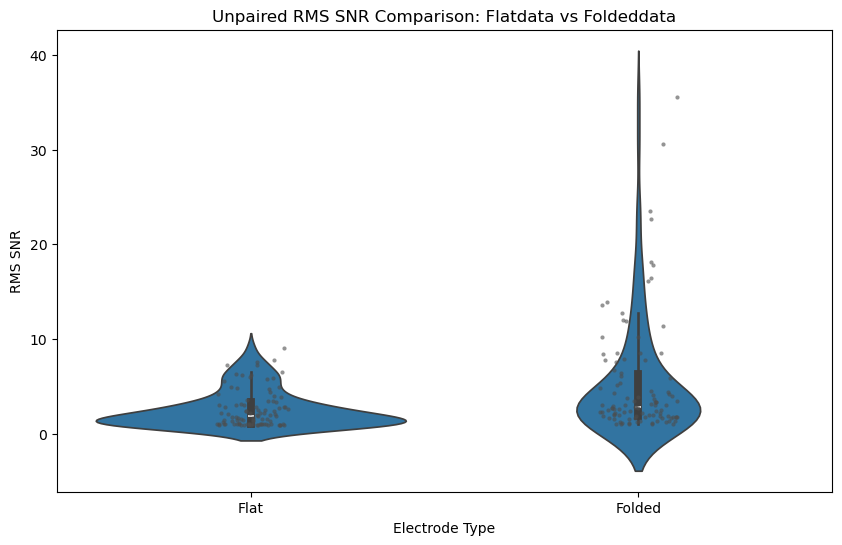

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def export_and_plot_unpaired_rms_snr_data(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\excel_data'
    os.makedirs(output_folder, exist_ok=True)

    data = []

    for condition in ['foldeddata', 'flatdata']:
        is_folded = condition == 'foldeddata'
        for folder, folder_data in snr_results[condition].items():
            for channel, values in folder_data.items():
                data.append({
                    'Folder': folder,
                    'Channel': channel,
                    'RMS SNR': values['RMS SNR'],
                    'Is Folded': is_folded
                })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Export to Excel
    excel_path = os.path.join(output_folder, 'unpaired_rms_snr_comparison_data.xlsx')
    df.to_excel(excel_path, index=False)

    print(f"Unpaired RMS SNR comparison data exported to: {excel_path}")
    print(f"Total data points: {len(df)}")
    print(f"Flatdata points: {len(df[~df['Is Folded']])}, Foldeddata points: {len(df[df['Is Folded']])}")

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Is Folded', y='SNR', data=df)
    sns.stripplot(x='Is Folded', y='SNR', data=df, color=".3", size=3, alpha=0.6)

    plt.title('Unpaired RMS SNR Comparison: Flatdata vs Foldeddata')
    plt.xlabel('Electrode Type')
    plt.ylabel('SNR')
    plt.xticks([0, 1], ['Flat', 'Folded'])

    # Show plot
    plt.show()

# Assuming snr_results is already populated from the previous code
export_and_plot_unpaired_rms_snr_data(snr_results)

In [ ]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

def export_and_plot_unpaired_rms_snr_data(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\excel_data'
    os.makedirs(output_folder, exist_ok=True)

    data = []

    for condition in ['foldeddata', 'flatdata']:
        is_folded = condition == 'foldeddata'
        for folder, folder_data in snr_results[condition].items():
            for channel, values in folder_data.items():
                data.append({
                    'Folder': folder,
                    'Channel': channel,
                    'RMS SNR': values['RMS SNR'],
                    'Is Folded': is_folded
                })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Export to Excel
    excel_path = os.path.join(output_folder, 'unpaired_rms_snr_comparison_data.xlsx')
    df.to_excel(excel_path, index=False)

    # Perform statistical test
    flat_data = df[~df['Is Folded']]['RMS SNR']
    folded_data = df[df['Is Folded']]['RMS SNR']
    statistic, p_value = stats.mannwhitneyu(flat_data, folded_data, alternative='two-sided')

    # Set figure size and colors
    plt.figure(figsize=(10, 6))
    colors = ['#2ecc71', '#e74c3c']  # Green for flat, Red for folded

    # Create box plot with thicker lines
    bp = sns.boxplot(x='Is Folded', y='RMS SNR', data=df, 
                     palette=colors,
                     width=0.5,
                     showfliers=False,
                     linewidth=2)

    # Add individual points with jitter
    sns.stripplot(x='Is Folded', y='RMS SNR', data=df,
                 jitter=True,
                 size=4,
                 alpha=0.3,
                 palette=colors)

    # Add significance annotation
    y_max = df['RMS SNR'].max()
    y_range = y_max

    bar_height = y_max + y_range * 0.1

    # Add significance bar with thicker line
    plt.plot([0, 0, 1, 1], 
             [bar_height, bar_height + y_range * 0.05, bar_height + y_range * 0.05, bar_height], 
             color='black', 
             linewidth=2.5)

    # Add significance asterisks
    if p_value < 0.001:
        sig_symbol = '***'
    elif p_value < 0.01:
        sig_symbol = '**'
    elif p_value < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'

    plt.text(0.5, bar_height + y_range * 0.07, sig_symbol, 
             horizontalalignment='center', fontsize=14)

    # Set background color to white
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')

    # Restore axes and labels
    plt.xticks([0, 1], ['Flat', 'Folded'], fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Electrode Type', fontsize=12)
    plt.ylabel('RMS SNR', fontsize=12)

    # Set y-axis to start from 0
    plt.ylim(0, bar_height + y_range * 0.2)

    # Keep only the bottom and left spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    return df, p_value

export_and_plot_unpaired_rms_snr_data(snr_results)

D:\temp\ipykernel_16448\3255860959.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='Is Folded', y='RMS SNR', data=df,
D:\temp\ipykernel_16448\3255860959.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Is Folded', y='RMS SNR', data=df,


(                                       Folder  Channel    RMS SNR  Is Folded
 0             co3 day2 in media_240313_193854        1   2.959356       True
 1             co3 day2 in media_240313_193854        3  30.635990       True
 2             co3 day2 in media_240313_193854        4  16.106015       True
 3             co3 day2 in media_240313_193854        5  22.631031       True
 4             co3 day2 in media_240313_193854        6   8.560533       True
 ..                                        ...      ...        ...        ...
 195  Unfolded MEA FY CO2 day 22_240511_160700        9   2.405466      False
 196  Unfolded MEA FY CO2 day 22_240511_160700       10   2.689433      False
 197  Unfolded MEA FY CO2 day 22_240511_160700       11   2.237224      False
 198  Unfolded MEA FY CO2 day 22_240511_160700       12   2.148505      False
 199  Unfolded MEA FY CO2 day 22_240511_160700       13   3.172611      False
 
 [200 rows x 4 columns],
 9.132818170631737e-06)

In [49]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

def export_and_plot_unpaired_rms_snr_data(snr_results):
    output_folder = r'E:\Desktop\omipolar\DataPlotting\SNRCalculation\selected_spikes\excel_data'
    os.makedirs(output_folder, exist_ok=True)

    data = []

    for condition in ['foldeddata', 'flatdata']:
        is_folded = condition == 'foldeddata'
        for folder, folder_data in snr_results[condition].items():
            for channel, values in folder_data.items():
                data.append({
                    'Folder': folder,
                    'Channel': channel,
                    'RMS SNR': values['RMS SNR'],
                    'Is Folded': is_folded
                })

    # Create DataFrame
    df = pd.DataFrame(data)


    # Count the number of samples for each class
    sample_counts = df.groupby('Is Folded').size()

    # Print the sample counts
    print("Number of samples for each class:")
    print(sample_counts)


    # Export to Excel
    excel_path = os.path.join(output_folder, 'unpaired_rms_snr_comparison_data.xlsx')
    df.to_excel(excel_path, index=False)

    # Perform statistical test
    flat_data = df[~df['Is Folded']]['RMS SNR']
    folded_data = df[df['Is Folded']]['RMS SNR']
    statistic, p_value = stats.mannwhitneyu(flat_data, folded_data, alternative='two-sided')

    # Set figure size and colors
    plt.figure(figsize=(10, 6))
    colors = ['#2ecc71', '#e74c3c']  # Green for flat, Red for folded

    # Create box plot with thicker lines
    bp = sns.boxplot(x='Is Folded', y='RMS SNR', data=df, 
                     palette=colors,
                     width=0.5,
                     showfliers=False,
                     linewidth=2)

    # Add individual points with jitter
    sns.stripplot(x='Is Folded', y='RMS SNR', data=df,
                 jitter=True,
                 size=4,
                 alpha=0.3,
                 palette=colors)

    # Add significance annotation
    y_max = df['RMS SNR'].max()
    y_range = y_max

    bar_height = y_max + y_range * 0.1

    # Add significance bar with thicker line
    plt.plot([0, 0, 1, 1], 
             [bar_height, bar_height + y_range * 0.05, bar_height + y_range * 0.05, bar_height], 
             color='black', 
             linewidth=2.5)

    # Add significance asterisks
    if p_value < 0.001:
        sig_symbol = '***'
    elif p_value < 0.01:
        sig_symbol = '**'
    elif p_value < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'

    plt.text(0.5, bar_height + y_range * 0.07, sig_symbol, 
             horizontalalignment='center', fontsize=14)

    # Set background color to white
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')

    # Remove all text and ticks
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')

    # Set y-axis to start from 0
    plt.ylim(0, bar_height + y_range * 0.2)

    # Keep only bottom and left spines, make them thicker
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Make visible spines thicker
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    return df, p_value

export_and_plot_unpaired_rms_snr_data(snr_results)

Number of samples for each class:
Is Folded
False     97
True     103
dtype: int64


D:\temp\ipykernel_16448\1267345417.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='Is Folded', y='RMS SNR', data=df,
D:\temp\ipykernel_16448\1267345417.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Is Folded', y='RMS SNR', data=df,


(                                       Folder  Channel    RMS SNR  Is Folded
 0             co3 day2 in media_240313_193854        1   2.959356       True
 1             co3 day2 in media_240313_193854        3  30.635990       True
 2             co3 day2 in media_240313_193854        4  16.106015       True
 3             co3 day2 in media_240313_193854        5  22.631031       True
 4             co3 day2 in media_240313_193854        6   8.560533       True
 ..                                        ...      ...        ...        ...
 195  Unfolded MEA FY CO2 day 22_240511_160700        9   2.405466      False
 196  Unfolded MEA FY CO2 day 22_240511_160700       10   2.689433      False
 197  Unfolded MEA FY CO2 day 22_240511_160700       11   2.237224      False
 198  Unfolded MEA FY CO2 day 22_240511_160700       12   2.148505      False
 199  Unfolded MEA FY CO2 day 22_240511_160700       13   3.172611      False
 
 [200 rows x 4 columns],
 9.132818170631737e-06)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats

def create_channel_wise_snr_comparison(snr_results):
    # Initialize dictionaries to store SNR values by channel
    flat_channel_snr = defaultdict(list)
    folded_channel_snr = defaultdict(list)
    
    # Collect SNR values for each channel and condition
    for condition in ['foldeddata', 'flatdata']:
        for folder, data in snr_results[condition].items():
            for channel, values in data.items():
                if condition == 'foldeddata':
                    folded_channel_snr[channel].append(values['RMS SNR'])
                else:
                    flat_channel_snr[channel].append(values['RMS SNR'])
    
    # Calculate mean SNR for each channel
    flat_mean_snr = {channel: np.mean(snrs) for channel, snrs in flat_channel_snr.items()}
    folded_mean_snr = {channel: np.mean(snrs) for channel, snrs in folded_channel_snr.items()}
    
    # Create scatter plot
    plt.figure(figsize=(12, 10))
    
    x = []
    y = []
    channels = []
    
    # Collect data points for plotting
    for channel in set(flat_mean_snr.keys()) | set(folded_mean_snr.keys()):
        if channel in flat_mean_snr and channel in folded_mean_snr:
            x.append(flat_mean_snr[channel])
            y.append(folded_mean_snr[channel])
            channels.append(channel)
    
    # Create scatter plot with larger circles
    plt.scatter(x, y, s=200, alpha=0.6)
    
    # Add channel labels to points with larger font
    for i, channel in enumerate(channels):
        plt.annotate(channel, (x[i], y[i]), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=18)
    
    # Add diagonal line extending to 10
    plt.plot([0, 10], [0, 10], 'r--', linewidth=3)
    
    # Calculate statistics
    all_flat_snr = [snr for snrs in flat_channel_snr.values() for snr in snrs]
    all_folded_snr = [snr for snrs in folded_channel_snr.values() for snr in snrs]
    
    t_stat, p_value = stats.ttest_ind(all_folded_snr, all_flat_snr)
    
    folded_mean = np.mean(all_folded_snr)
    flat_mean = np.mean(all_flat_snr)
    percent_difference = ((folded_mean - flat_mean) / flat_mean) * 100
    
    # Remove all labels and ticks
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    plt.xticks([])
    plt.yticks([])
    
    # Set equal aspect ratio and limits
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Remove legend
    plt.gca().get_legend().remove() if plt.gca().get_legend() else None
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
    return {
        'flat_mean': flat_mean,
        'folded_mean': folded_mean,
        'p_value': p_value,
        'percent_difference': percent_difference
    }

In [33]:
create_channel_wise_snr_comparison(snr_results)

{'flat_mean': 2.6040551053006133,
 'folded_mean': 5.339659477247339,
 'p_value': 4.6243867352831055e-05,
 'percent_difference': 105.05170825219253}

In [46]:
from scipy.stats import pearsonr, spearmanr

def create_distance_difference_plot_with_correlation(snr_results):
    # Define distance mapping for each electrode (convert keys to integers)
    distance_map = {
        1: 400, 5: 400, 9: 400, 13: 400,
        0: 1200, 3: 1200, 4: 1200, 7: 1200, 
        8: 1200, 11: 1200, 12: 1200, 15: 1200,
        2: 2000, 6: 2000, 10: 2000, 14: 2000
    }
    
    flat_channel_snr = defaultdict(list)
    folded_channel_snr = defaultdict(list)
    
    for condition in ['foldeddata', 'flatdata']:
        for folder, data in snr_results[condition].items():
            for channel, values in data.items():
                if condition == 'foldeddata':
                    folded_channel_snr[channel].append(values['RMS SNR'])
                else:
                    flat_channel_snr[channel].append(values['RMS SNR'])
    
    flat_mean_snr = {channel: np.mean(snrs) for channel, snrs in flat_channel_snr.items() if snrs}
    folded_mean_snr = {channel: np.mean(snrs) for channel, snrs in folded_channel_snr.items() if snrs}
    
    x = []
    y = []
    
    for channel in set(flat_mean_snr.keys()) & set(folded_mean_snr.keys()):
        if channel in distance_map:
            difference = folded_mean_snr[channel] - flat_mean_snr[channel]
            x.append(distance_map[channel])
            y.append(difference)
    
    print(f"Distances (X): {x}")
    print(f"Differences (Y): {y}")
    
    # Calculate correlation
    if x and y:
        pearson_corr, pearson_p = pearsonr(x, y)
        spearman_corr, spearman_p = spearmanr(x, y)
    else:
        pearson_corr, pearson_p = None, None
        spearman_corr, spearman_p = None, None
    
    # Plotting
    plt.figure(figsize=(12, 10))
    if x and y:
        plt.scatter(x, y)
        plt.xlim(min(x) - 100, max(x) + 100)
        plt.ylim(min(y) - 1, max(y) + 1)
        plt.xlabel("Distance (mm)")
        plt.ylabel("SNR Difference")
        plt.title(f"SNR Difference by Electrode Distance\nPearson r={pearson_corr:.2f} (p={pearson_p:.3f}), Spearman r={spearman_corr:.2f} (p={spearman_p:.3f})")
    else:
        print("No data to plot.")
    
    plt.show()
    
    return {
        'distances': x,
        'differences': y,
        'pearson_correlation': pearson_corr,
        'pearson_p_value': pearson_p,
        'spearman_correlation': spearman_corr,
        'spearman_p_value': spearman_p
    }


In [47]:
create_distance_difference_plot_with_correlation(snr_results)

Distances (X): [1200, 400, 2000, 1200, 1200, 400, 2000, 1200, 1200, 400, 2000, 1200, 1200, 400, 2000, 1200]
Differences (Y): [-0.5497690233227779, 0.2605082134239236, -0.1823469427627531, 5.803014909651576, 3.4445114058959385, 3.996445033034226, 1.0783928750260916, 0.10390370519552583, 0.7127770806434244, 1.8859664715827598, 6.25053358236078, 6.753029197924006, 2.754945388501798, 3.0852272423364266, 3.223631669143333, 3.7767153635686705]


{'distances': [1200,
  400,
  2000,
  1200,
  1200,
  400,
  2000,
  1200,
  1200,
  400,
  2000,
  1200,
  1200,
  400,
  2000,
  1200],
 'differences': [-0.5497690233227779,
  0.2605082134239236,
  -0.1823469427627531,
  5.803014909651576,
  3.4445114058959385,
  3.996445033034226,
  1.0783928750260916,
  0.10390370519552583,
  0.7127770806434244,
  1.8859664715827598,
  6.25053358236078,
  6.753029197924006,
  2.754945388501798,
  3.0852272423364266,
  3.223631669143333,
  3.7767153635686705],
 'pearson_correlation': 0.044797415397737364,
 'pearson_p_value': 0.8691520290206922,
 'spearman_correlation': 0.0,
 'spearman_p_value': 1.0}